# DATASET

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

/Users/comibear/miniconda3/envs/robotics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MuJoCo:[3.1.6]


In [2]:
dataset = DATASETS[41] # asu_table_top_converted_externally_to_rlds
display_key = 'image'

ds, iterator = get_dataset(dataset, display_key=display_key)

2025-02-03 16:21:02.193258: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


FeaturesDict({
    'episode_metadata': FeaturesDict({
        'file_path': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(7,), dtype=float32),
        'action_delta': Tensor(shape=(7,), dtype=float32),
        'action_inst': Text(shape=(), dtype=string),
        'discount': Scalar(shape=(), dtype=float32),
        'goal_object': Text(shape=(), dtype=string),
        'ground_truth_states': FeaturesDict({
            'EE': Tensor(shape=(6,), dtype=float32),
            'bottle': Tensor(shape=(6,), dtype=float32),
            'bread': Tensor(shape=(6,), dtype=float32),
            'coke': Tensor(shape=(6,), dtype=float32),
            'cube': Tensor(shape=(6,), dtype=float32),
            'milk': Tensor(shape=(6,), dtype=float32),
            'pepsi': Tensor(shape=(6,), dtype=float32),
        }),
        'is_first': bool,
        'is_last': bool,
        'is_terminal': bool,
        'language_embedding': Tensor(shape=(512,), dtype=float32),
 

In [3]:
episode = next(iterator)
images = get_image_from_episode(episode, display_key=display_key)

import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-02-03 16:21:06.192249: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-03 16:21:41.132830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 1 of 30
2025-02-03 16:21:46.419562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-03 16:21:46.479566: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE

In [67]:
iter_steps = iter(episode['steps'])
states = [state['observation']['state'] for state in iter_steps]

################################################################################################
bias = [3.016681, -0.297434 + np.pi/2, 0, 1.804528, 6.157572, -0.008899] # NGD
states = [(np.array(state[:6]) - np.array(bias)) * np.array([1,1,-1,1,1,1]) for state in states]
################################################################################################


iter_steps = iter(episode['steps'])
EEF = [state['ground_truth_states']['EE'] for state in iter_steps]

iter_steps = iter(episode['steps'])
actions = [state['action'] for state in iter_steps]

# ENV

In [7]:
xml_path = '../mujoco_menagerie/universal_robots_ur5e/scene.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL

In [73]:
# Visualize environment with initial pose from trajectory
env.init_viewer(
    title='Tabletop',
    transparent=False,
    azimuth=133,
    distance=3.5,
    elevation=-42.4,
    lookat=(-0.06,0.07,0.31),
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7']

env.reset()
env.forward(q=joint_states[60], joint_names=joint_names)

while env.is_viewer_alive():
  if env.loop_every(tick_every=10):
    env.plot_T(
        T=env.get_T_body(body_name='link_base'),
        axis_len=0.5,print_xyz=False)
    env.plot_text(
        p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
        label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
    
    env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    env.plot_contact_info(
        r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
    
    env.render()

env.close_viewer()

In [74]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7',] # Except fingers

# Don't Know Why.....
# q0 = np.array([0, -1, 0, 1, 6, 1.7, 0])

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[60]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(qpos,xyzrpyg[6]), #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        ctrl_idxs   = [0,1,2,3,4,5,6,7])
        #joint_names = joint_names)
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [62]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'Gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:-6,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:-6,1]).tolist() + [255],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:-6,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:-6,1]).tolist() + [255])],
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7'] # Except fingers

q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:7])
    
    env.step( # dynamic update
        ctrl        = np.append(qpos, joint_values[7]), # Last value is gripper
        ctrl_idxs   = [0,1,2,3,4,5,6,7])
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='link_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='link_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


# Trajectory

### 1) genration

In [28]:
joint_names = env.joint_names
q0 = np.zeros_like(len(joint_names), dtype=float)

q_traj = []

q_ik_init = q0.copy()
for ik_target in EEF:

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = np.array([ik_target[1], -ik_target[0], ik_target[2]]) + np.array([0.15, 0, 0]),
        R_trgt             = rpy2r(ik_target[3:]),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

### 2) Comparing

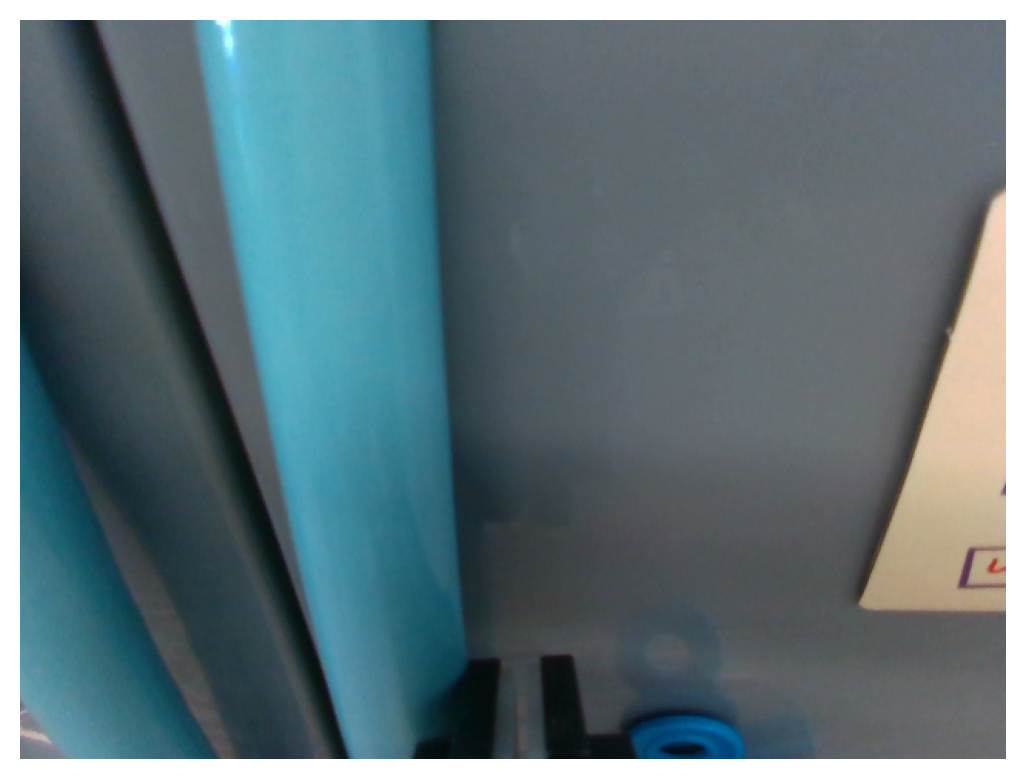

2025-01-22 19:34:10.292 python[10569:413082] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-22 19:34:10.292 python[10569:413082] +[IMKInputSession subclass]: chose IMKInputSession_Modern


ValueError: 'joint_finger_right' is not in list

In [8]:
# G -> B -> R

idx = -1
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = ['joint1','joint2','joint3','joint4','joint5','joint6','joint7',] # Except fingers

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),
        joint_names = joint_names)
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base_link'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base_link')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance

In [27]:
joint_names = env.joint_names
q0 = np.zeros_like(len(joint_names), dtype=float)

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]
        # gripper = gripper_states[idx]
        # qpos = np.append(qpos, [gripper, gripper])

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


In [68]:
joint_names = env.joint_names
q0 = np.zeros_like(len(joint_names), dtype=float)

env.init_viewer()

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = states[0][:6]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.5):
       
        if idx < len(states)-1:
            idx += 1
        else:
           idx = 0

        qpos = states[idx][:6]  # Use first 7 joints from joint_states

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print("Done.")

Done.


# Reverse Engineering

In [75]:
# current link gripper -> tcp_link rpy 0,0,0
# target link gripper -> target rpy

target = EEF[idx-1][3:]
target = quat2r(target)

base = env.get_R_body(body_name='link7')
current = env.get_R_body(body_name='tcp_link')

R = current.T@base
rpy = r2rpy(R)
# print(rpy)

R = base.T@target
rpy = r2rpy(R)
# print(rpy)
print(rpy2quat(rpy))


'''
[-5.27306031e-17  9.32701387e-17  1.57079633e+00]
[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]
[ 0.72716463  0.04836099  0.05041956 -0.68289874]
[ 0.70710678  0.          0.         -0.70710678]


[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]
'''

[ 0.00790343 -0.9974868  -0.07036702 -0.00246893]


'\n[-5.27306031e-17  9.32701387e-17  1.57079633e+00]\n[ 1.48438446e-03  1.39833212e-01 -1.50792732e+00]\n[ 0.72716463  0.04836099  0.05041956 -0.68289874]\n[ 0.70710678  0.          0.         -0.70710678]\n\n\n[9.99735615e-01 2.21498574e-02 9.10323765e-04 6.10366593e-03]\n'

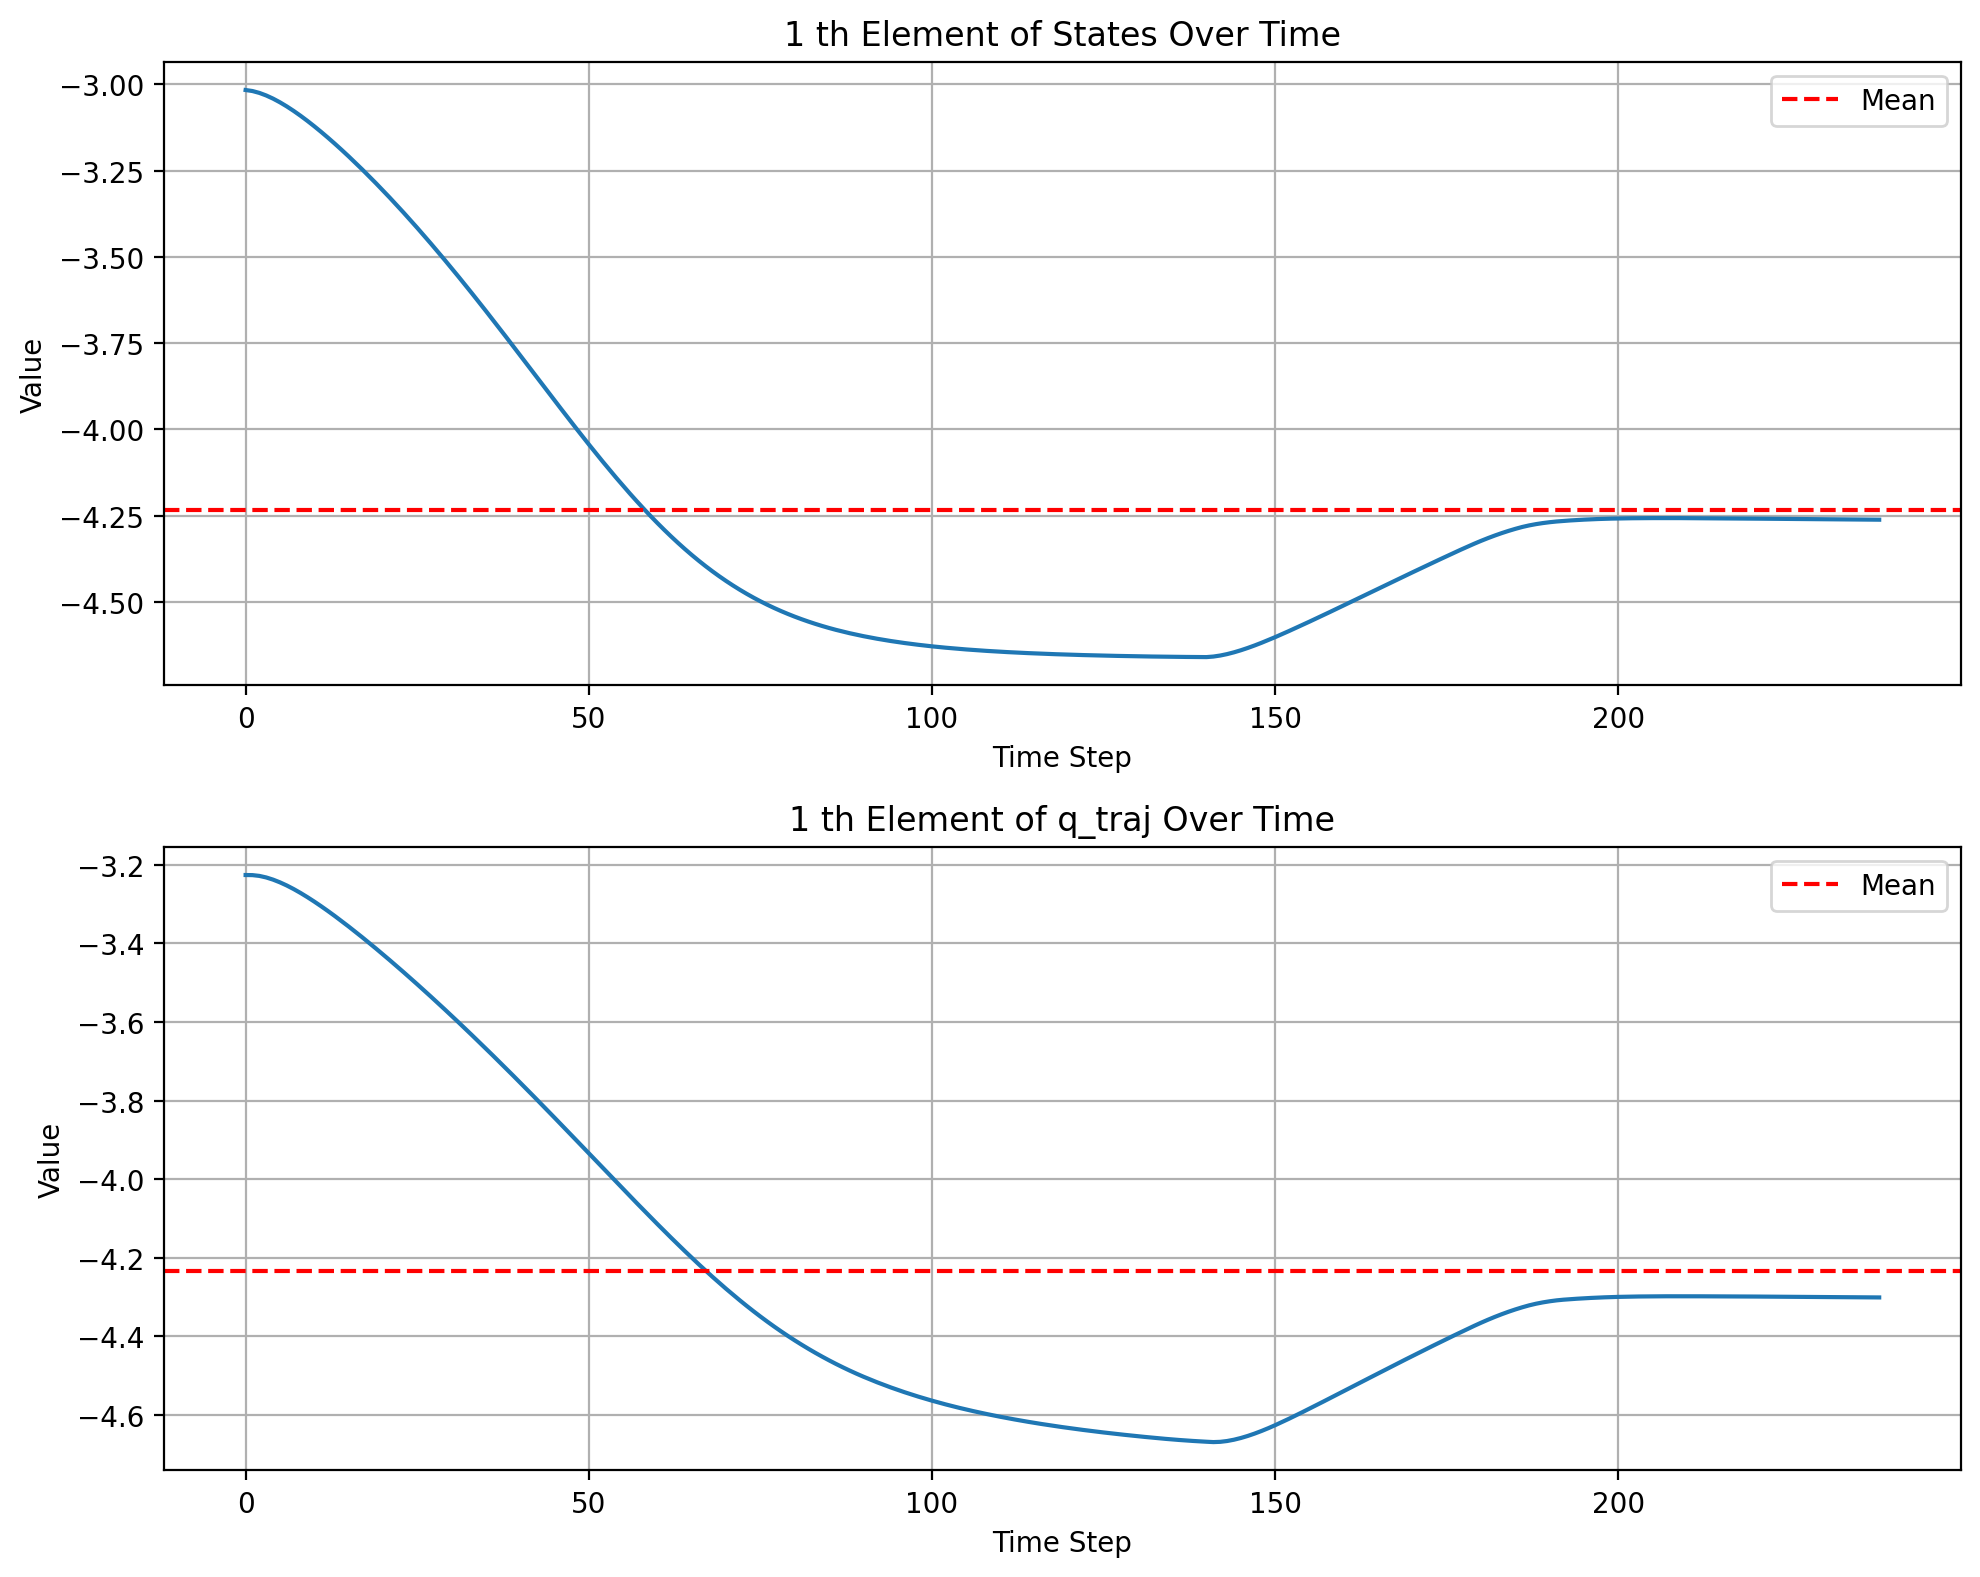

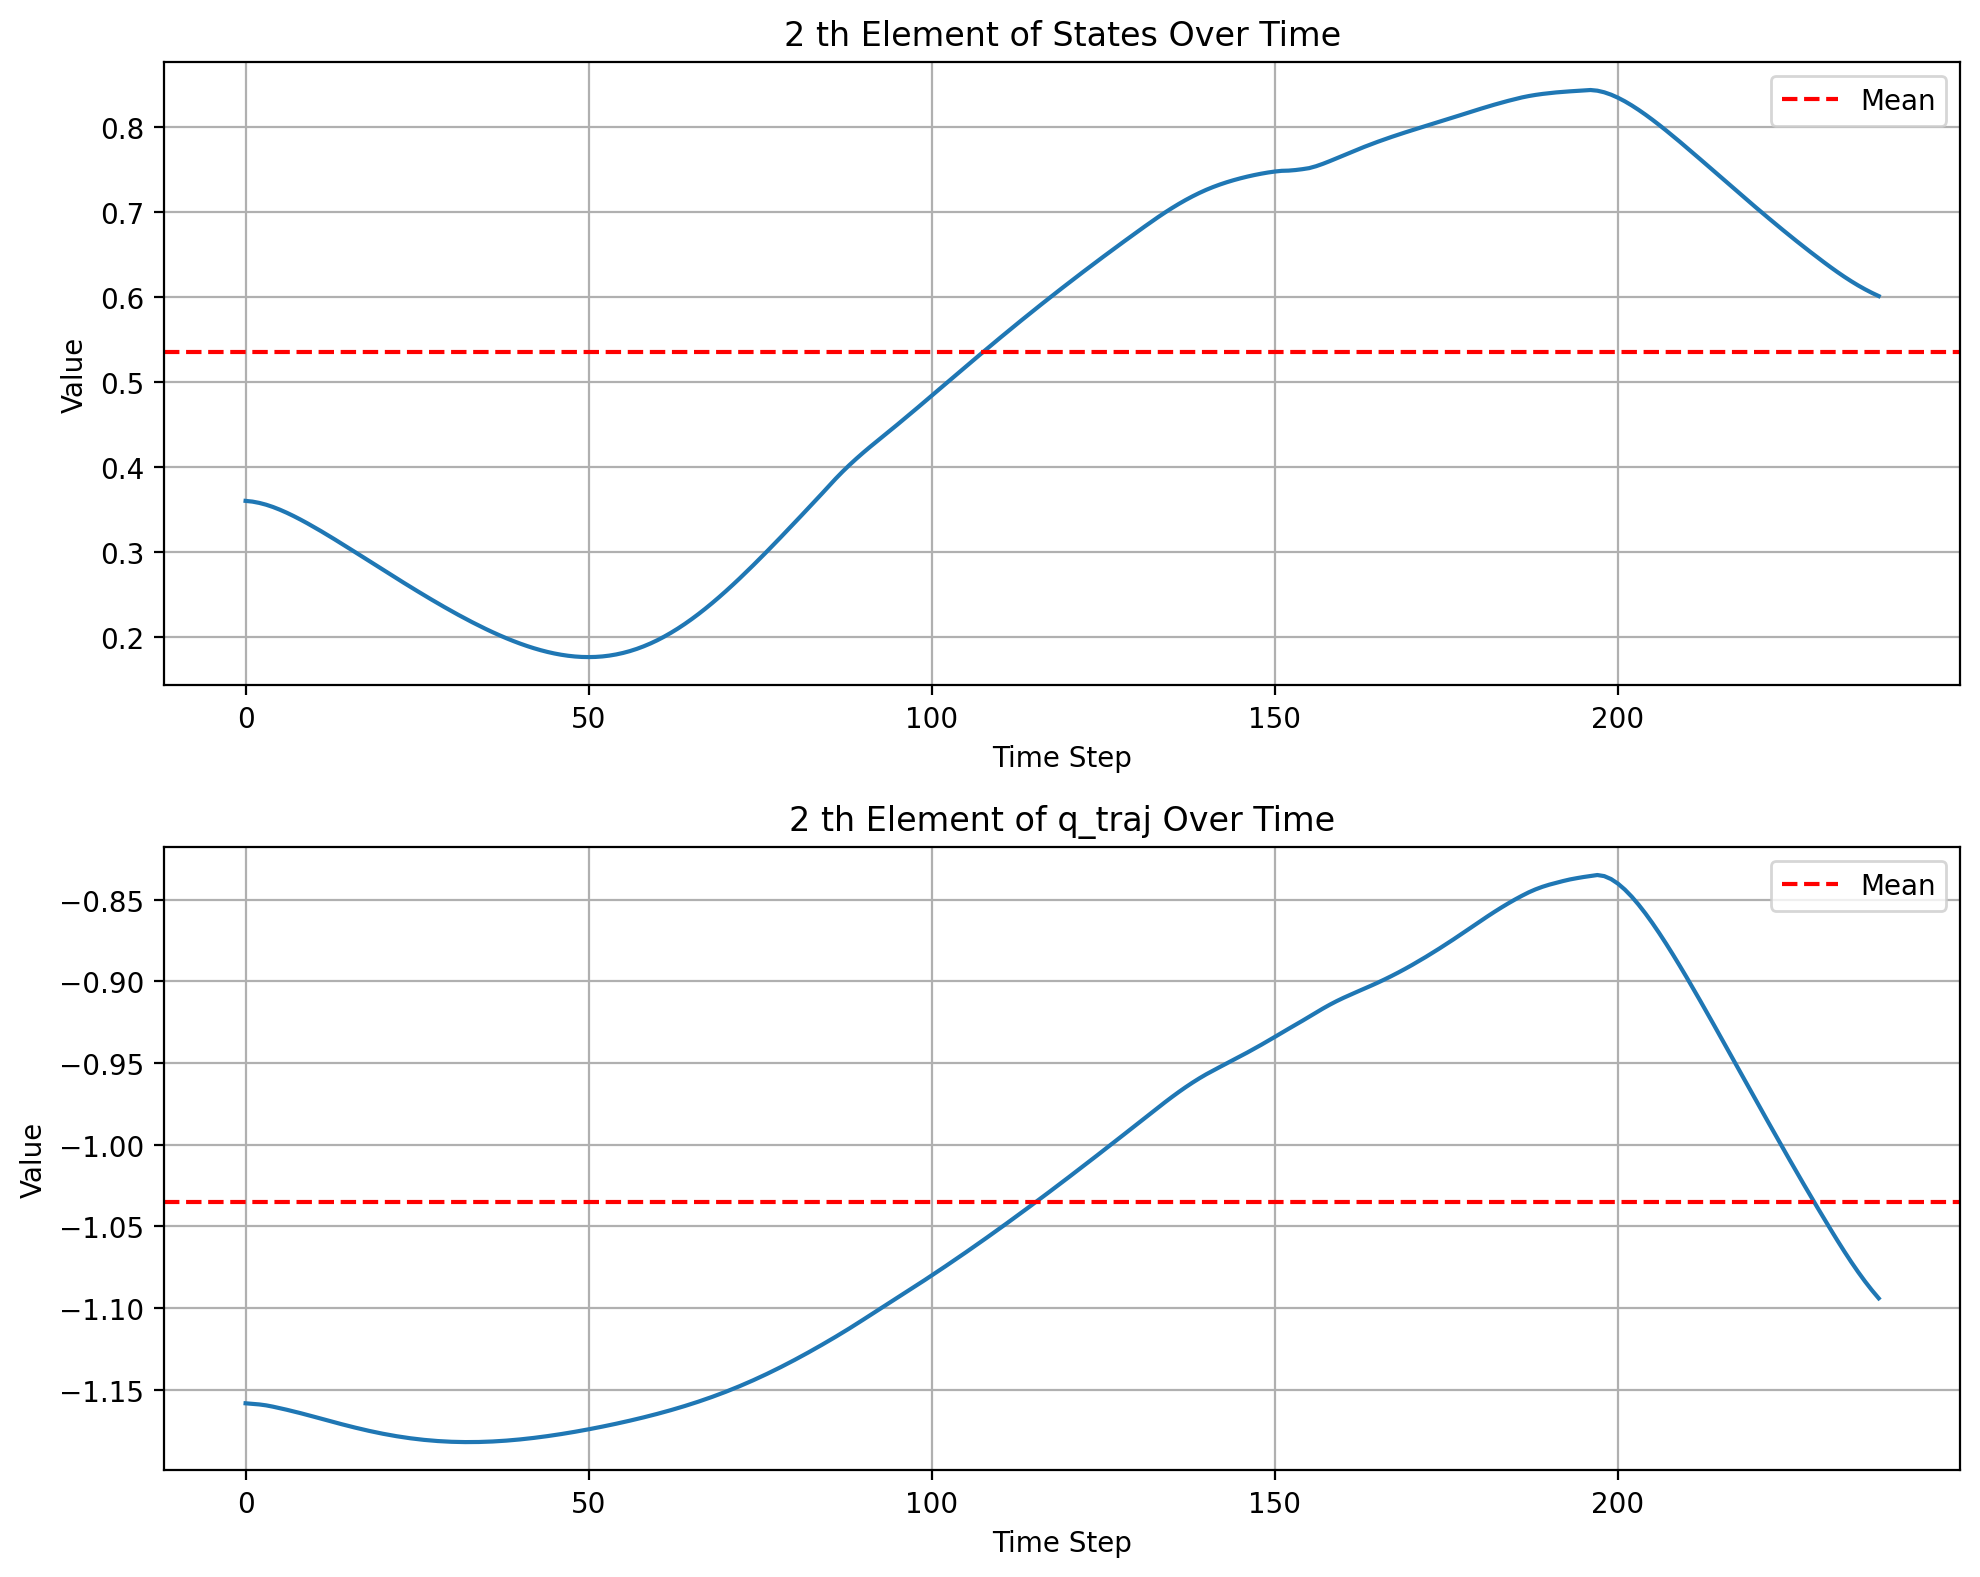

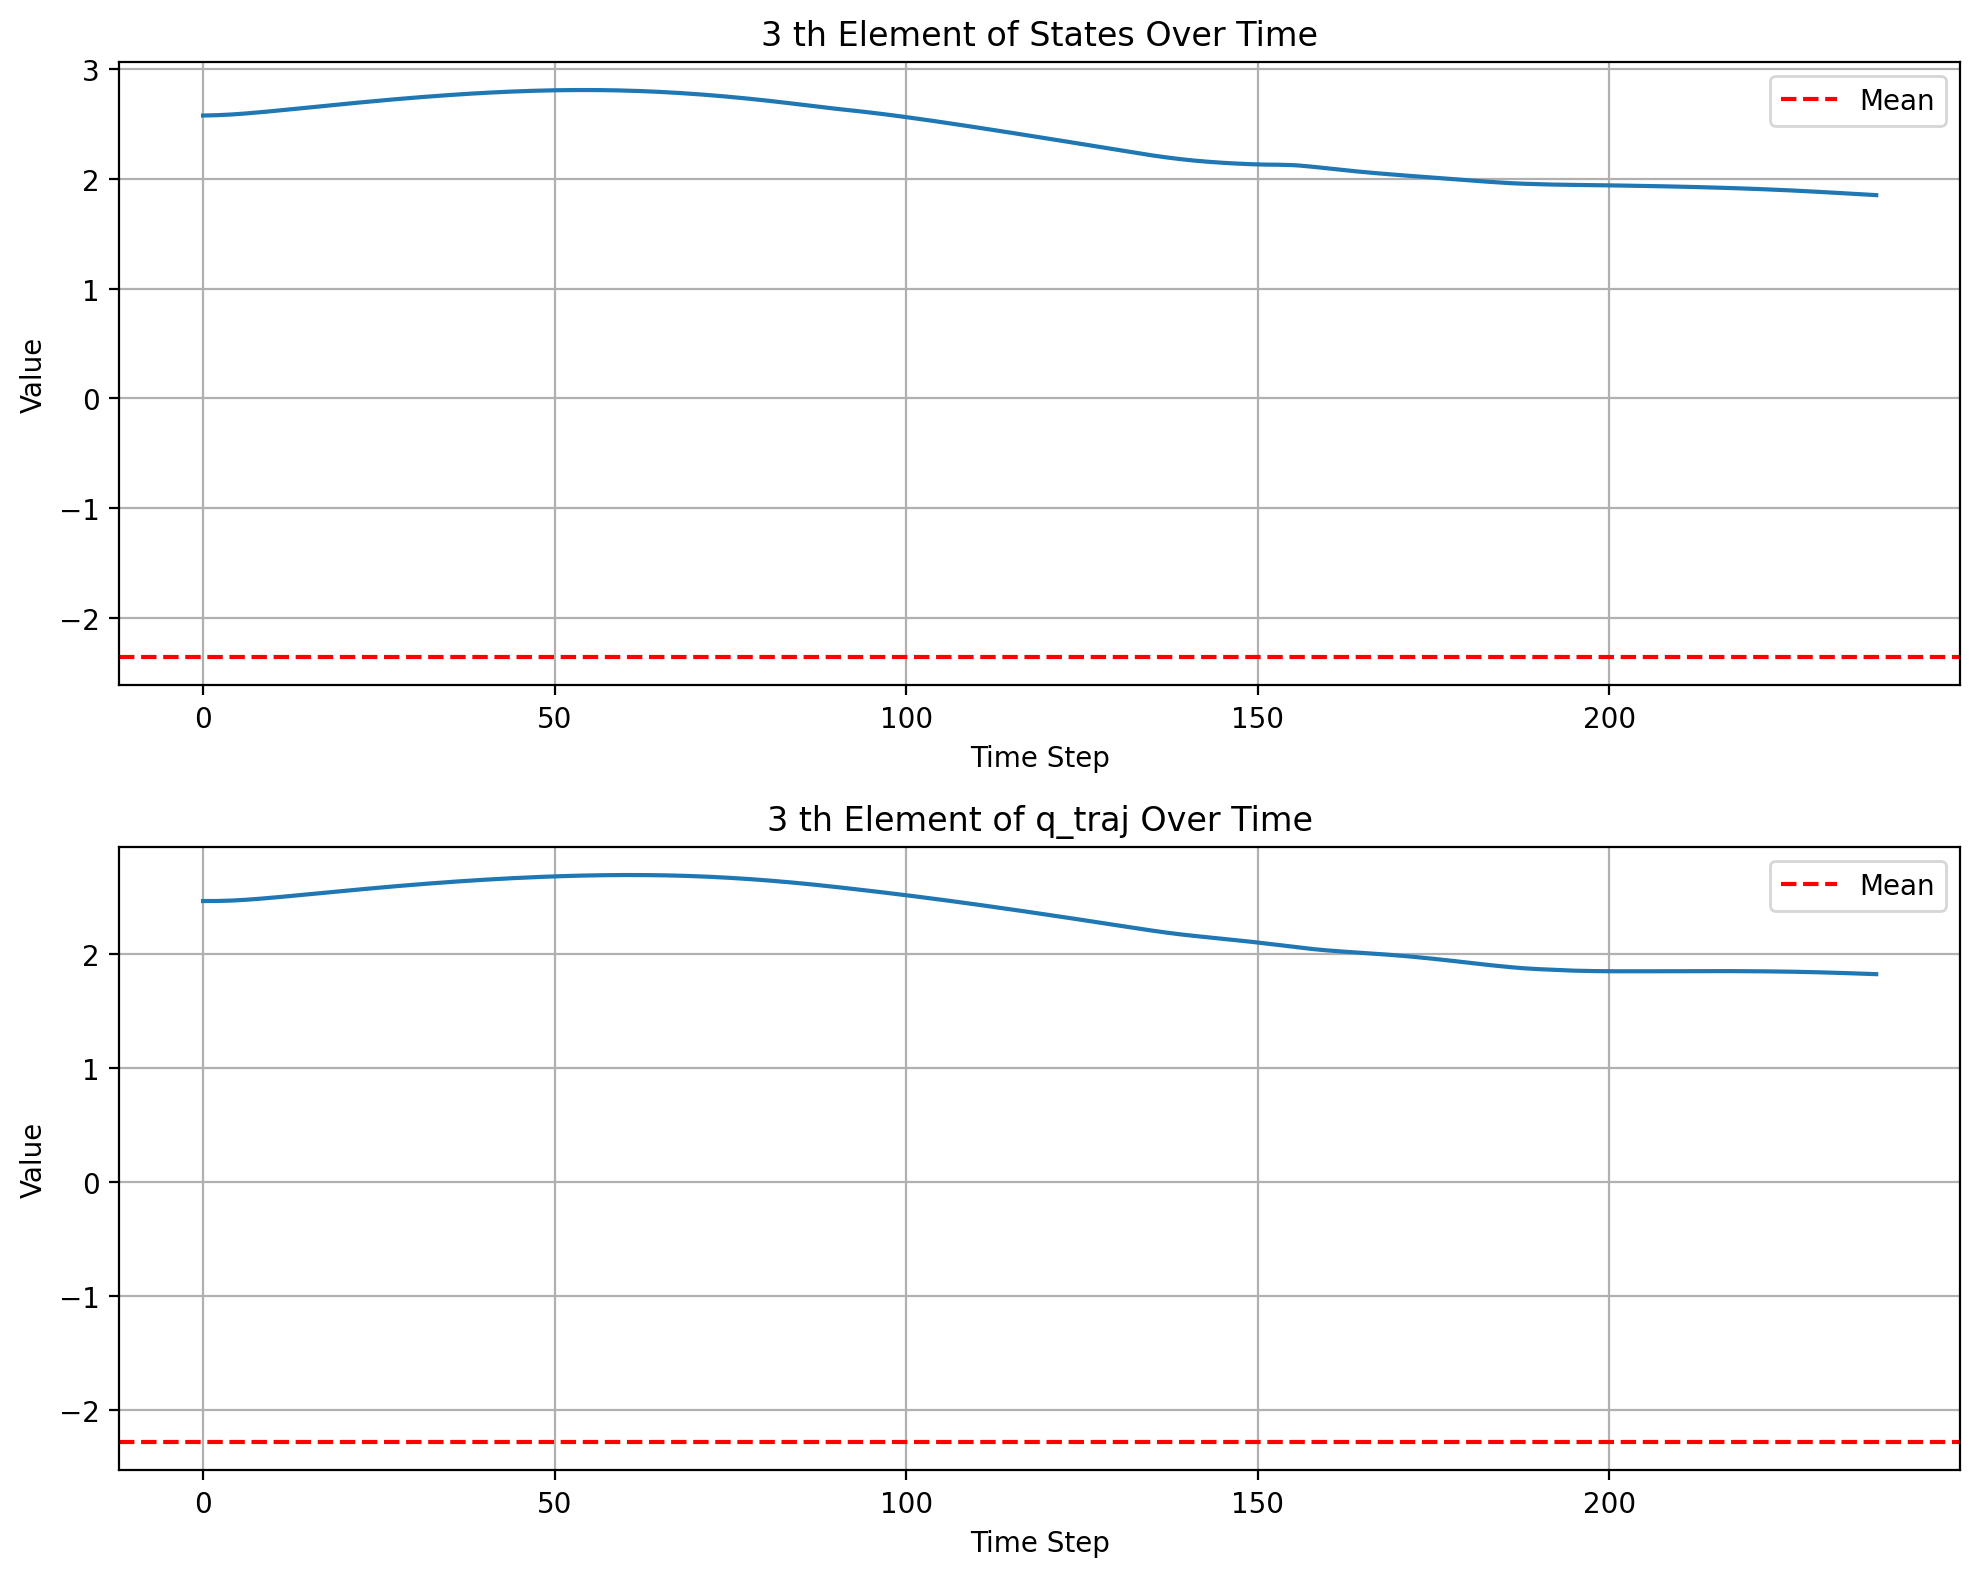

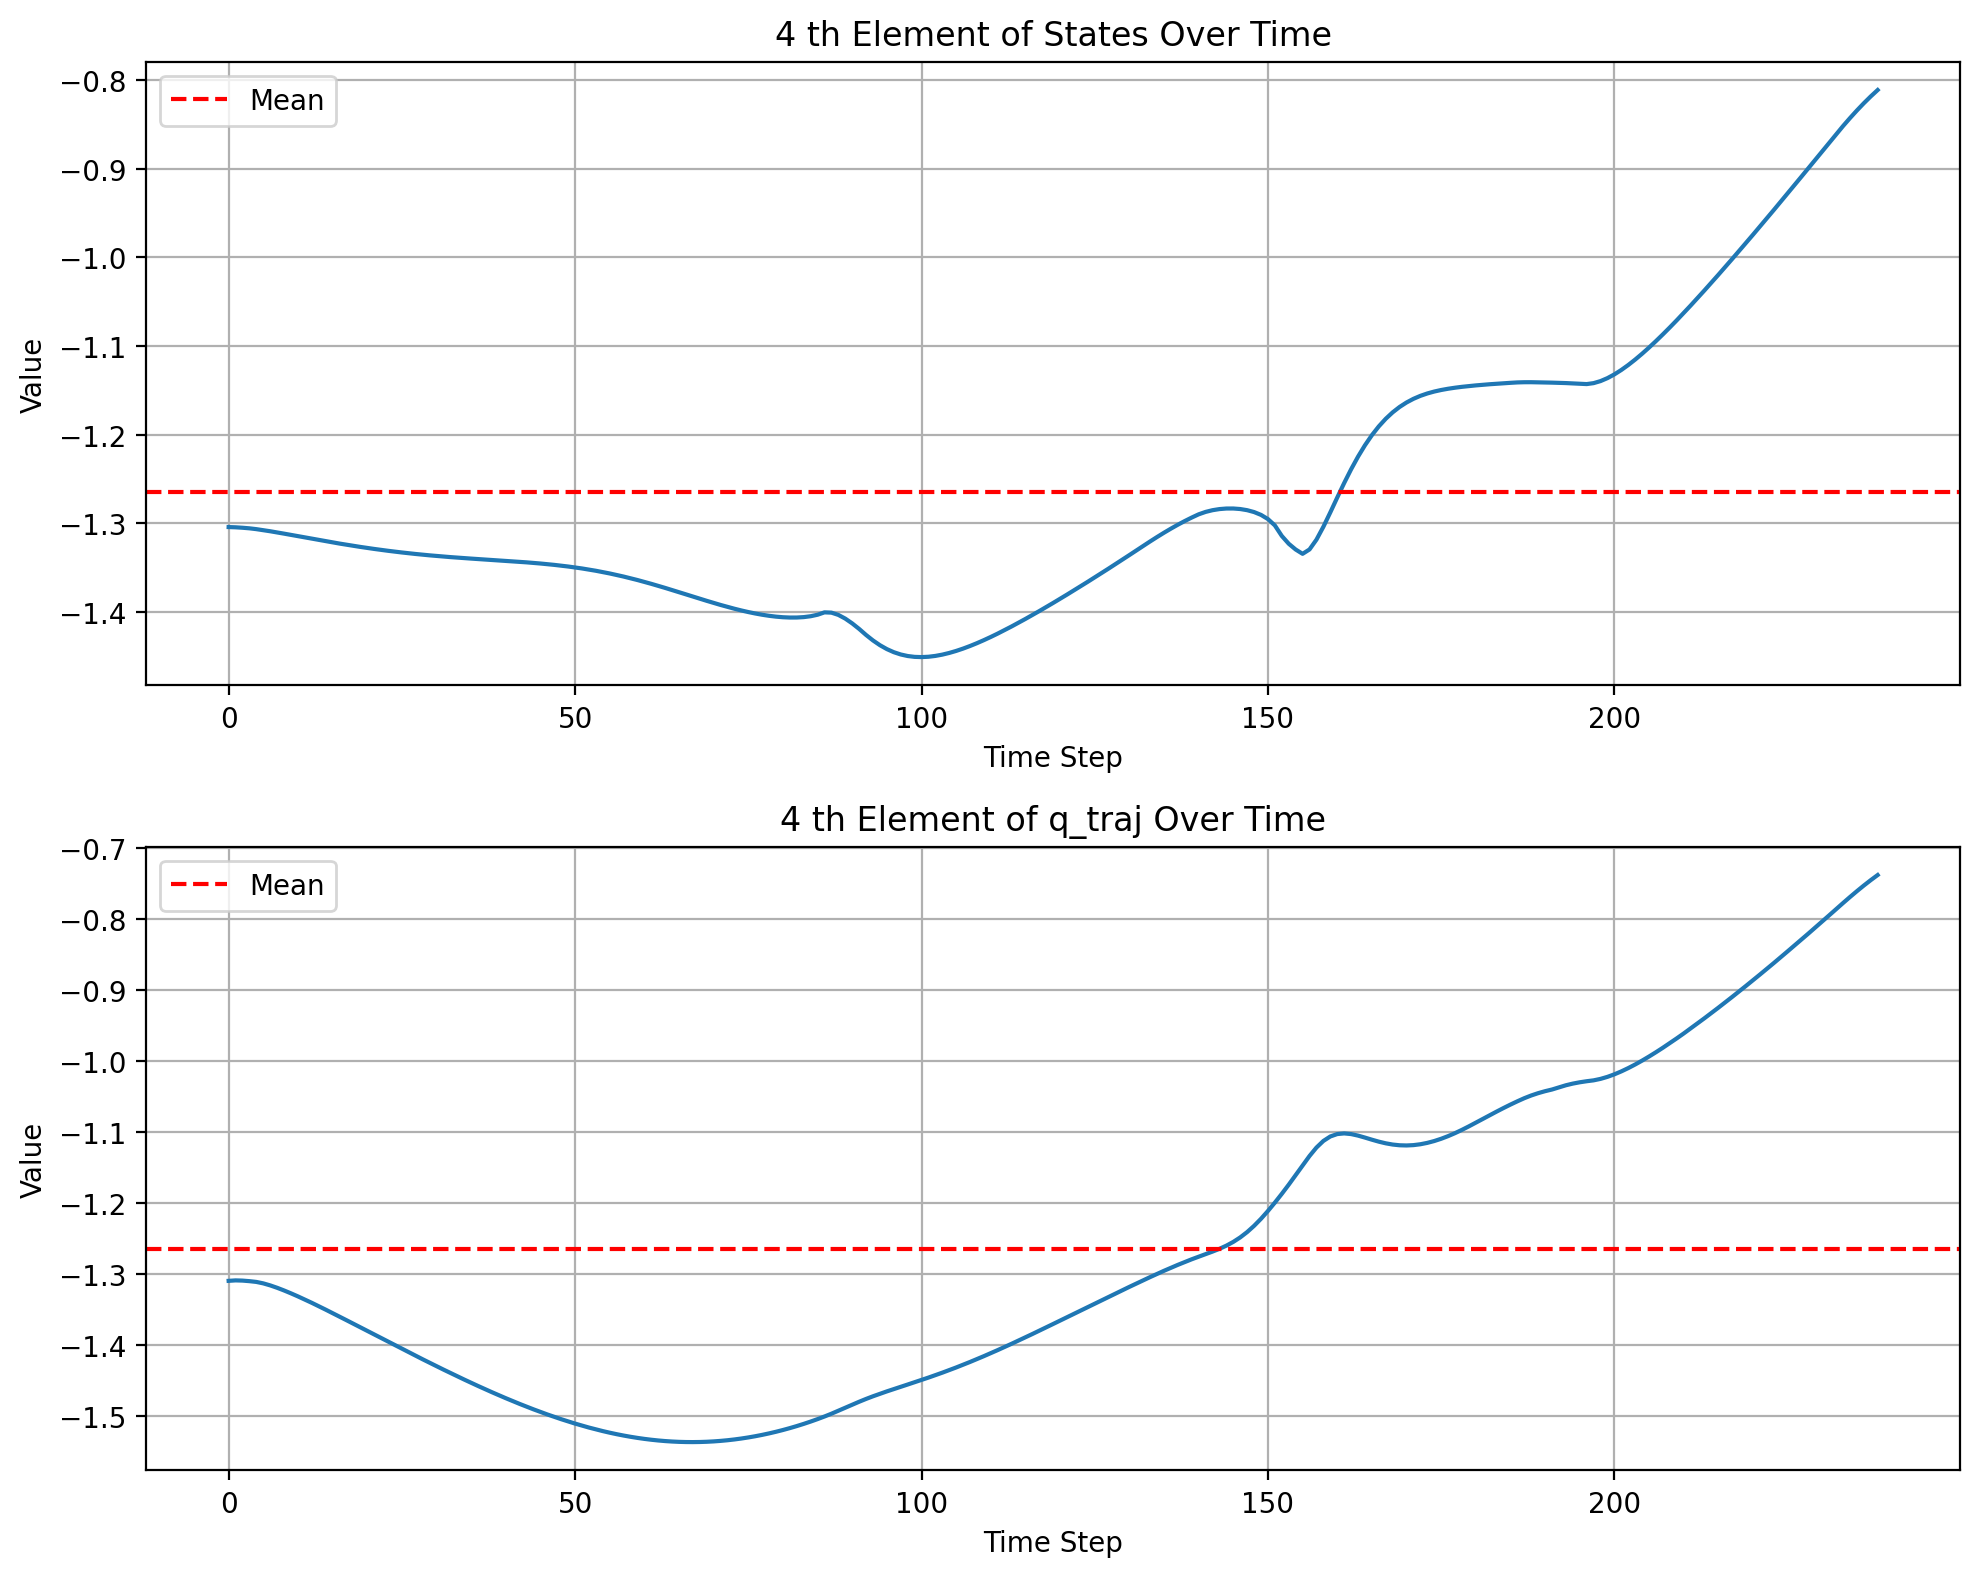

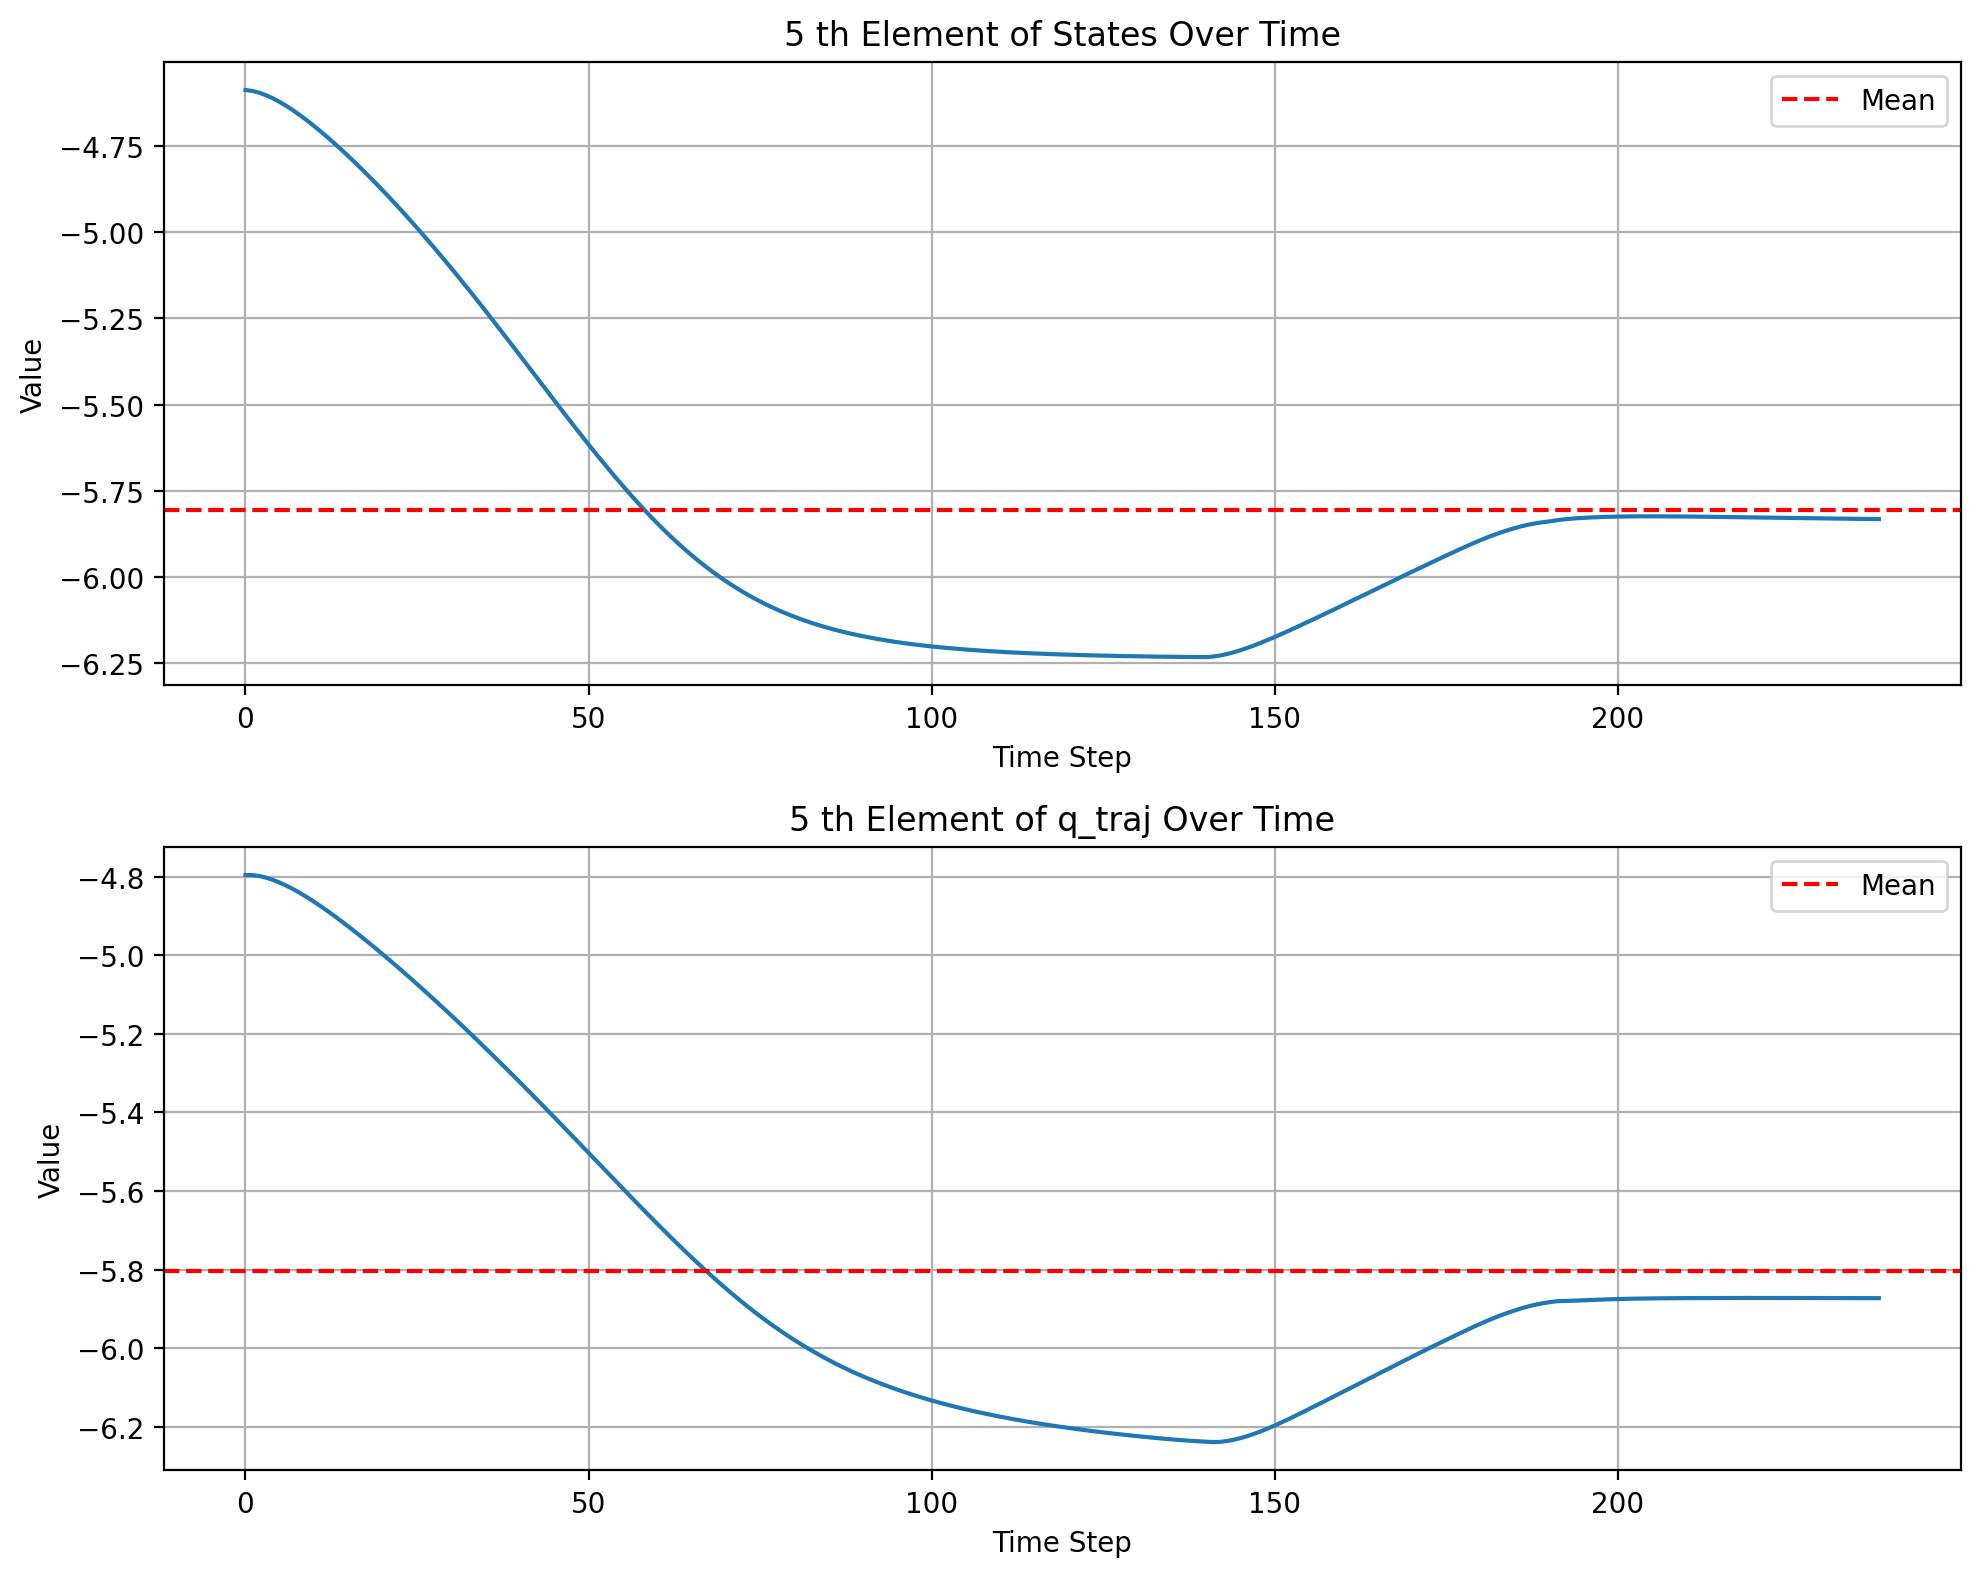

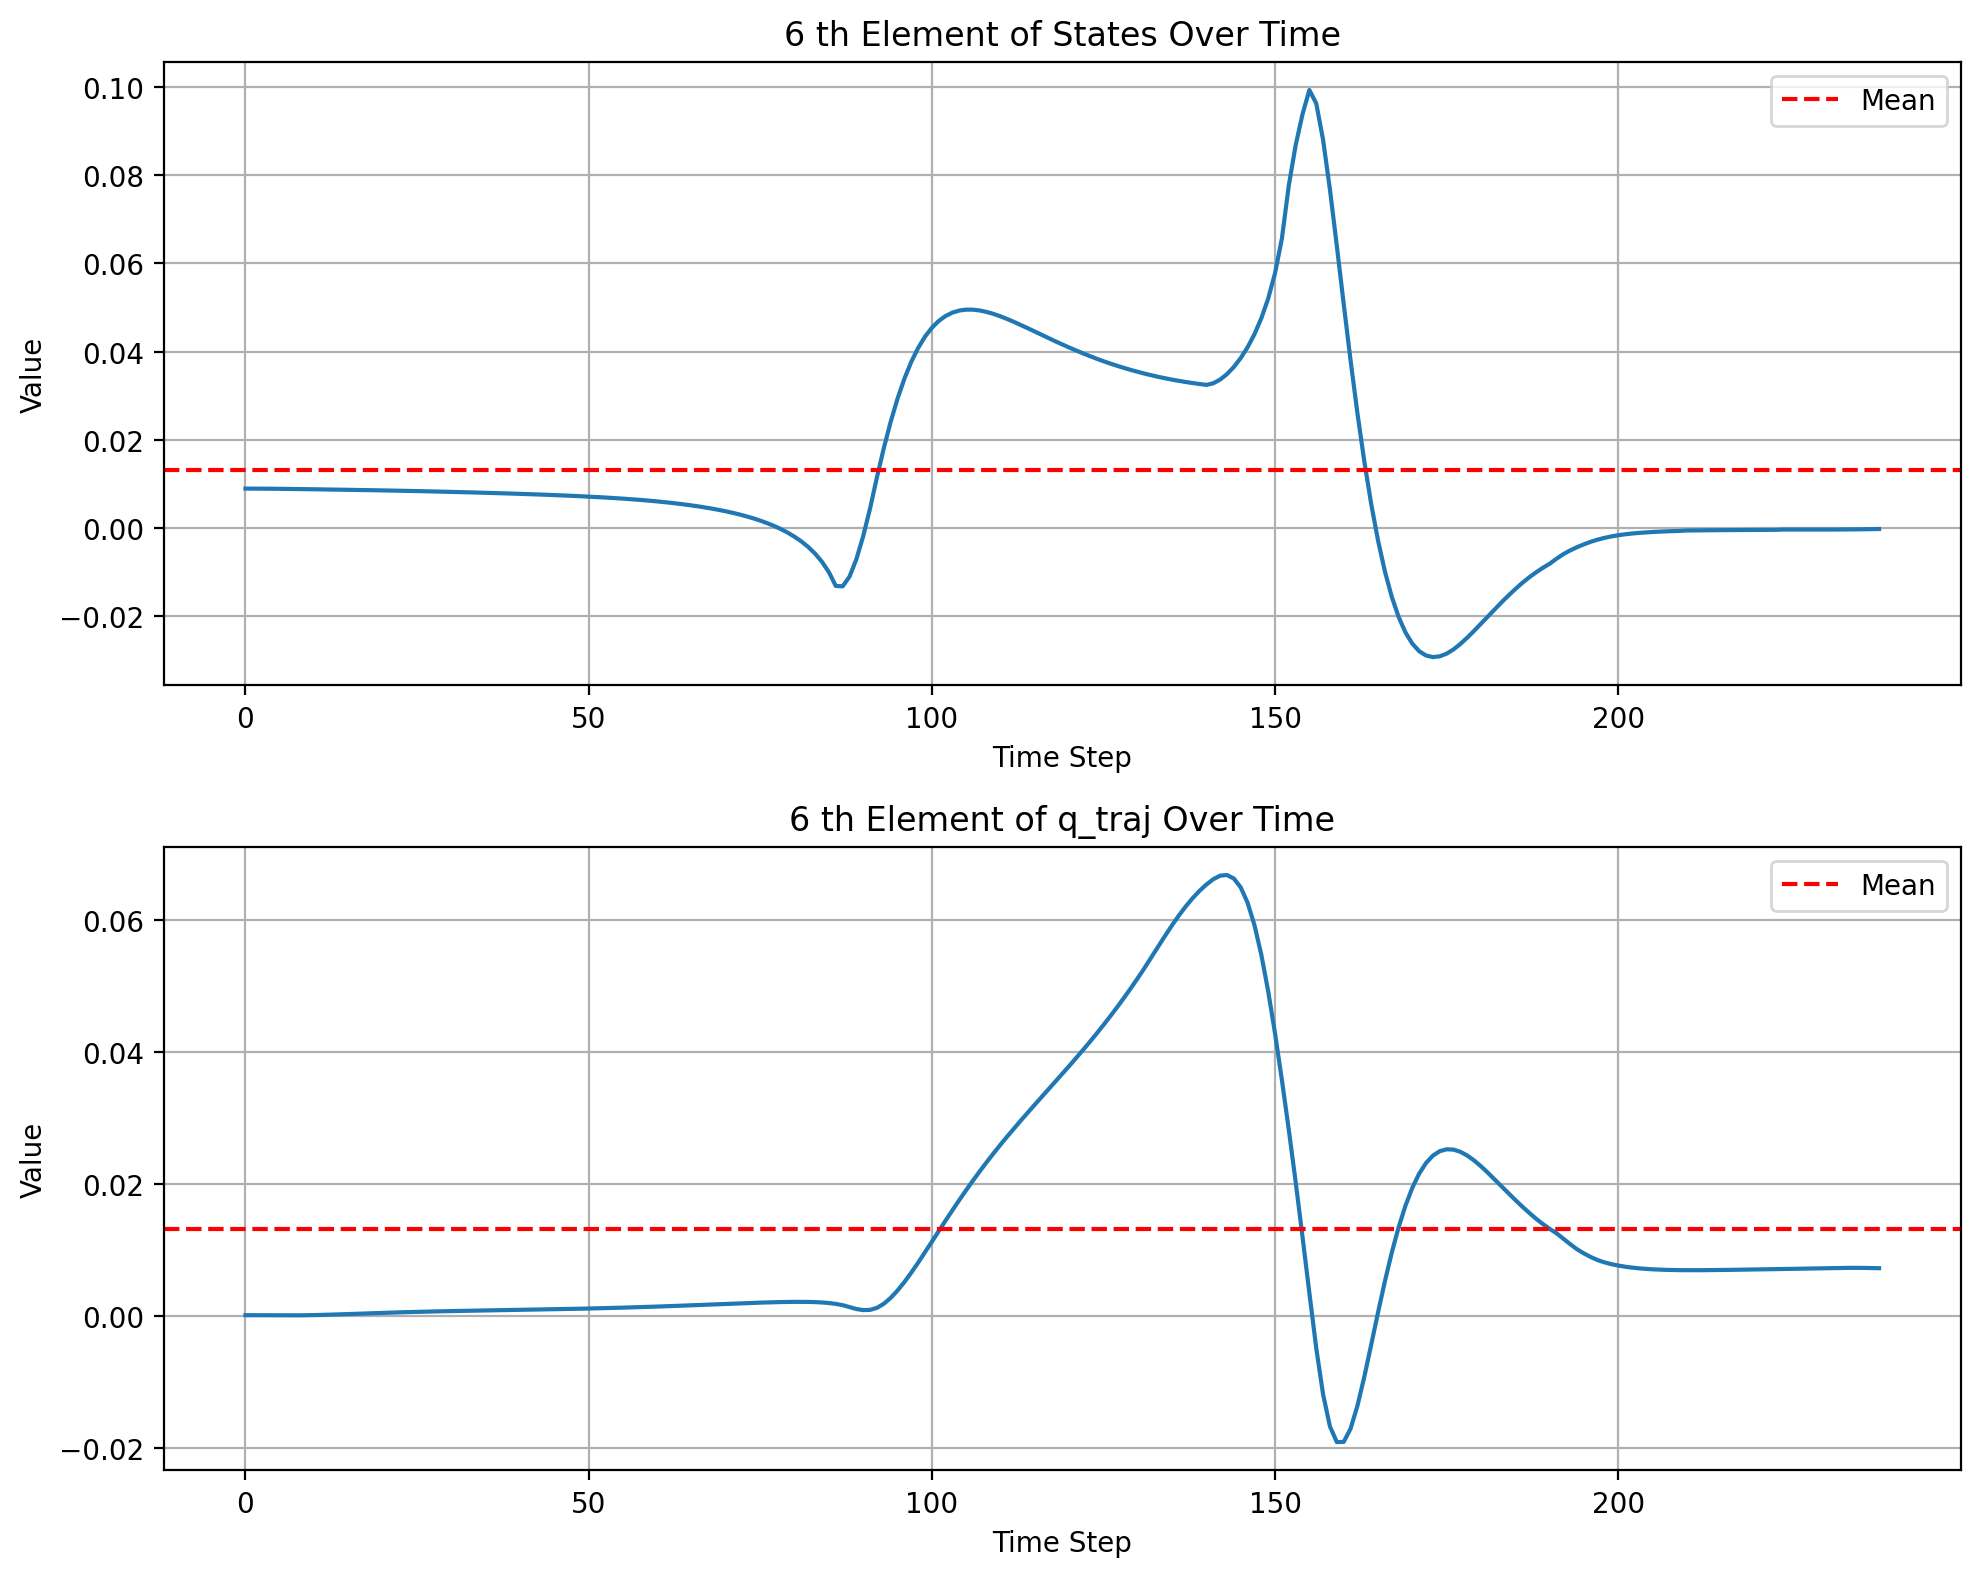

In [65]:
# Calculate and compare means for elements 0,1,3,4,5 and element 2 with negation
import matplotlib.pyplot as plt
import numpy as np

mean_differences = []

for i in range(6):
    # Extract i-th element from each state and trajectory
    states_first = [state[i] for state in states]
    q_traj_first = [q[i] for q in q_traj]

    # Calculate means
    if i == 2:
        # For element 2, negate values before calculating mean
        states_mean = np.mean([-x for x in states_first])
        q_traj_mean = np.mean([-x for x in q_traj_first])
    else:
        states_mean = np.mean(states_first)
        q_traj_mean = np.mean(q_traj_first)

    mean_differences.append(f"Element {i}: Mean difference (states - q_traj) = {states_mean - q_traj_mean:.6f}")

    # Create time points
    time_points = range(len(states))

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot states
    ax1.plot(time_points, states_first)
    ax1.axhline(y=states_mean, color='r', linestyle='--', label='Mean')
    ax1.set_title(f'{i+1} th Element of States Over Time')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Value')
    ax1.grid(True)
    ax1.legend()

    # Plot q_traj
    ax2.plot(time_points, q_traj_first)
    ax2.axhline(y=q_traj_mean, color='r', linestyle='--', label='Mean')
    ax2.set_title(f'{i+1} th Element of q_traj Over Time')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Value')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [66]:
mean_differences

['Element 0: Mean difference (states - q_traj) = 0.000001',
 'Element 1: Mean difference (states - q_traj) = 1.570796',
 'Element 2: Mean difference (states - q_traj) = -0.073471',
 'Element 3: Mean difference (states - q_traj) = -0.000000',
 'Element 4: Mean difference (states - q_traj) = 0.000000',
 'Element 5: Mean difference (states - q_traj) = 0.000000']

In [ ]:
[3.016681,
 -0.297434,
 4.645477,
 1.804528,
 6.157572,
 -0.008899]